In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.7.0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
IMAGE_SIZE = 128
EPOCHS = 100
BATCH = 8
LR = 1e-4

PATH = "Images/"

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "US images/*")))
    masks = sorted(glob(os.path.join(path, "Expert mask images/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  880
Validation data:  110
Testing data:  110


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

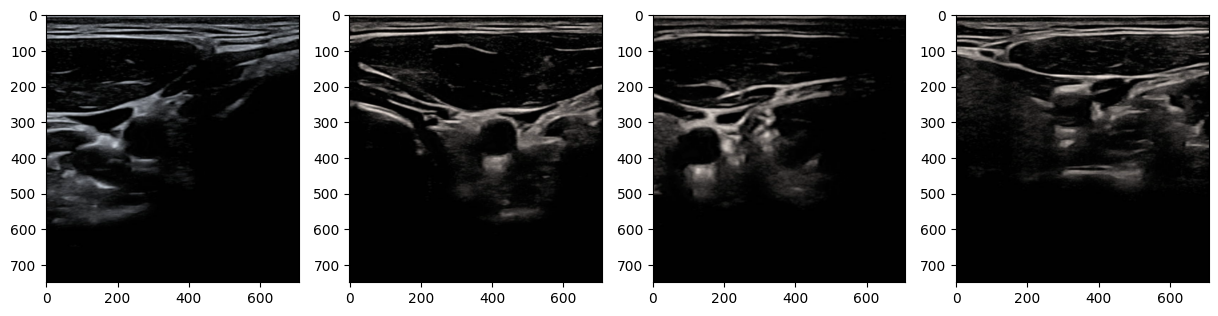

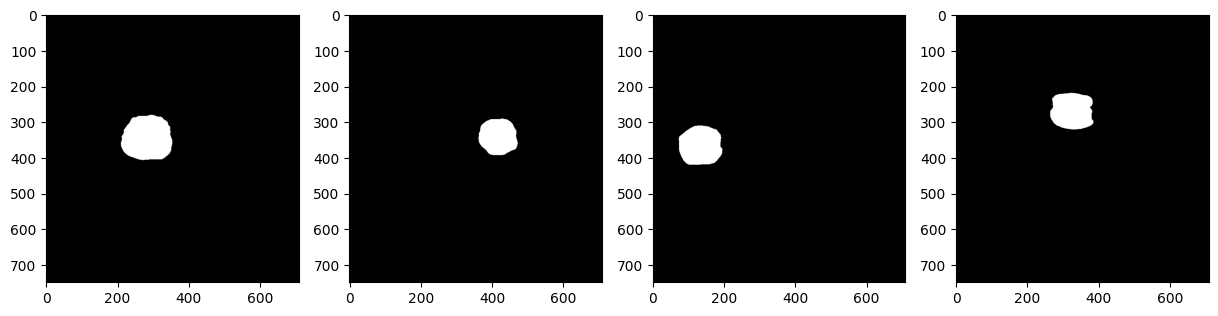

In [10]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [11]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [12]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']           

In [13]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [14]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [15]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [16]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [17]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/100
110/110 [==============================] - 78s 548ms/step - loss: 0.8539 - dice_coef: 0.1461 - recall: 0.9228 - precision: 0.2822 - val_loss: 0.9309 - val_dice_coef: 0.0691 - val_recall: 0.3784 - val_precision: 0.9471 - lr: 1.0000e-04
Epoch 2/100
110/110 [==============================] - 92s 838ms/step - loss: 0.7619 - dice_coef: 0.2381 - recall: 0.9939 - precision: 0.7156 - val_loss: 0.8739 - val_dice_coef: 0.1260 - val_recall: 0.6359 - val_precision: 0.9310 - lr: 1.0000e-04
Epoch 3/100
110/110 [==============================] - 123s 1s/step - loss: 0.7119 - dice_coef: 0.2881 - recall: 0.9939 - precision: 0.8178 - val_loss: 0.7960 - val_dice_coef: 0.2037 - val_recall: 0.7086 - val_precision: 0.9064 - lr: 1.0000e-04
Epoch 4/100
110/110 [==============================] - 93s 838ms/step - loss: 0.6741 - dice_coef: 0.3259 - recall: 0.9933 - precision: 0.8593 - val_loss: 0.7403 - val_dice_coef: 0.2593 - val_recall: 0.7377 - val_precision: 0.9159 - lr: 1.0000e-04
Epoch 5/100
11

110/110 [==============================] - 66s 600ms/step - loss: 0.0525 - dice_coef: 0.9475 - recall: 0.9765 - precision: 0.9912 - val_loss: 0.1076 - val_dice_coef: 0.8925 - val_recall: 0.8708 - val_precision: 0.9787 - lr: 1.0000e-04
Epoch 35/100
110/110 [==============================] - 66s 601ms/step - loss: 0.0494 - dice_coef: 0.9506 - recall: 0.9765 - precision: 0.9917 - val_loss: 0.1021 - val_dice_coef: 0.8980 - val_recall: 0.8776 - val_precision: 0.9761 - lr: 1.0000e-04
Epoch 36/100
110/110 [==============================] - 66s 603ms/step - loss: 0.0468 - dice_coef: 0.9532 - recall: 0.9764 - precision: 0.9915 - val_loss: 0.1041 - val_dice_coef: 0.8961 - val_recall: 0.8666 - val_precision: 0.9790 - lr: 1.0000e-04
Epoch 37/100
110/110 [==============================] - 67s 607ms/step - loss: 0.0442 - dice_coef: 0.9558 - recall: 0.9762 - precision: 0.9918 - val_loss: 0.0960 - val_dice_coef: 0.9042 - val_recall: 0.8785 - val_precision: 0.9778 - lr: 1.0000e-04
Epoch 38/100
110/110 

110/110 [==============================] - 70s 640ms/step - loss: 0.0154 - dice_coef: 0.9846 - recall: 0.9774 - precision: 0.9952 - val_loss: 0.0621 - val_dice_coef: 0.9380 - val_recall: 0.9344 - val_precision: 0.9487 - lr: 1.0000e-04
Epoch 68/100
110/110 [==============================] - 67s 610ms/step - loss: 0.0162 - dice_coef: 0.9838 - recall: 0.9768 - precision: 0.9944 - val_loss: 0.0602 - val_dice_coef: 0.9400 - val_recall: 0.9325 - val_precision: 0.9537 - lr: 1.0000e-05
Epoch 69/100
110/110 [==============================] - 77s 696ms/step - loss: 0.0151 - dice_coef: 0.9849 - recall: 0.9777 - precision: 0.9952 - val_loss: 0.0599 - val_dice_coef: 0.9403 - val_recall: 0.9313 - val_precision: 0.9552 - lr: 1.0000e-05
Epoch 70/100
110/110 [==============================] - 70s 634ms/step - loss: 0.0146 - dice_coef: 0.9854 - recall: 0.9782 - precision: 0.9958 - val_loss: 0.0598 - val_dice_coef: 0.9404 - val_recall: 0.9298 - val_precision: 0.9564 - lr: 1.0000e-05
Epoch 71/100
110/110 

In [18]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

14/14 [==============================] - 2s 156ms/step - loss: 0.0482 - dice_coef: 0.9519 - recall: 0.9417 - precision: 0.9680


[0.04821135848760605,
 0.9518721699714661,
 0.9416834712028503,
 0.9680128693580627]

In [19]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [20]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

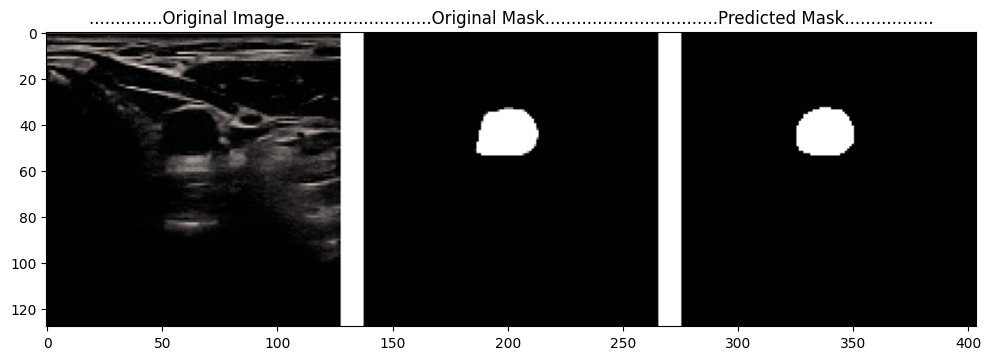

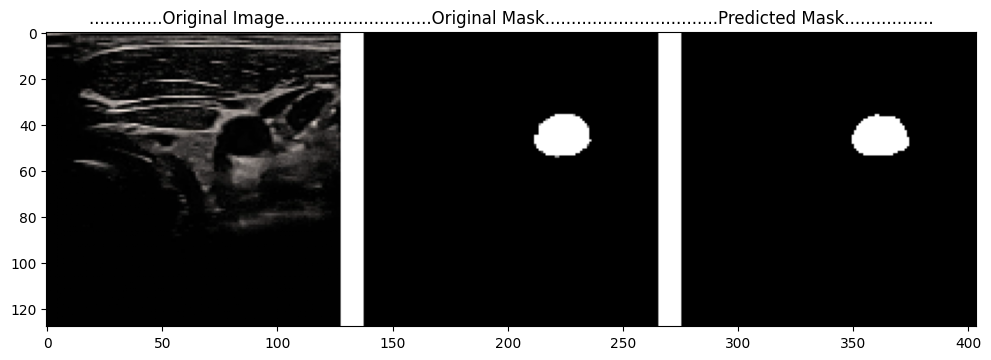

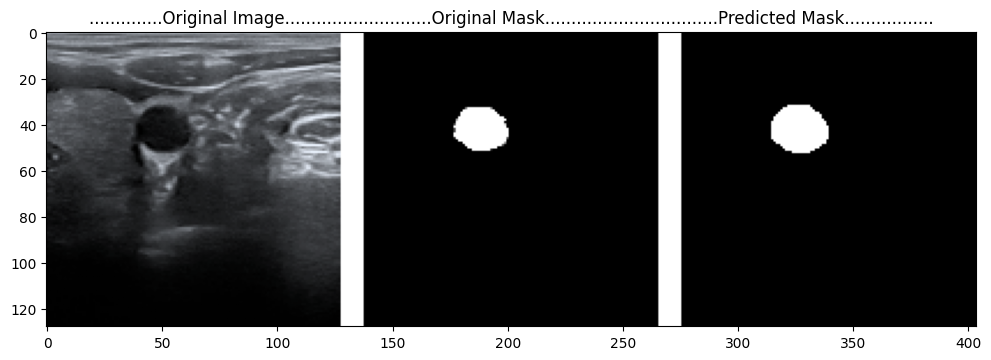

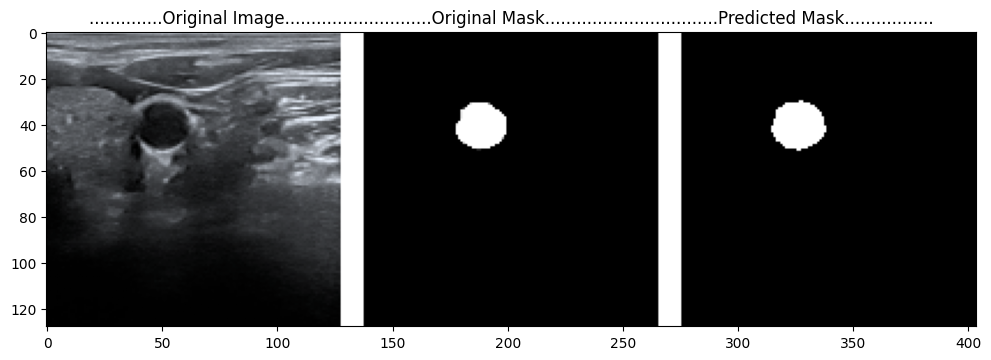

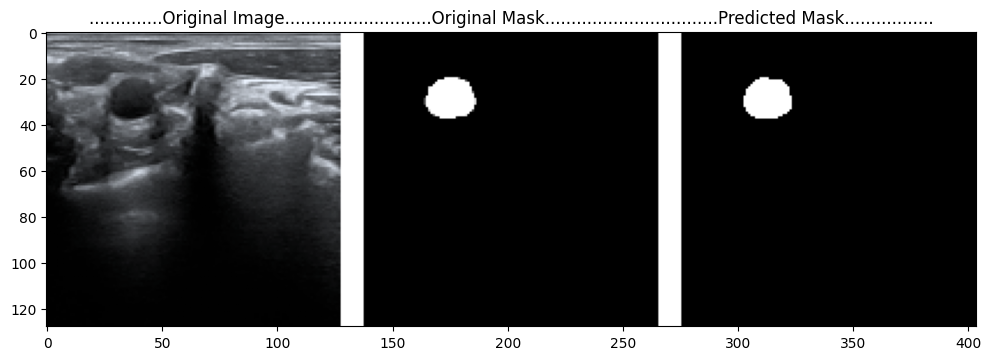

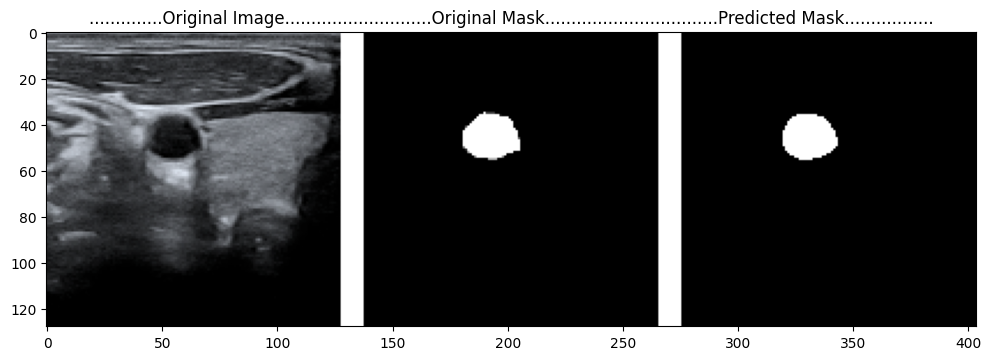

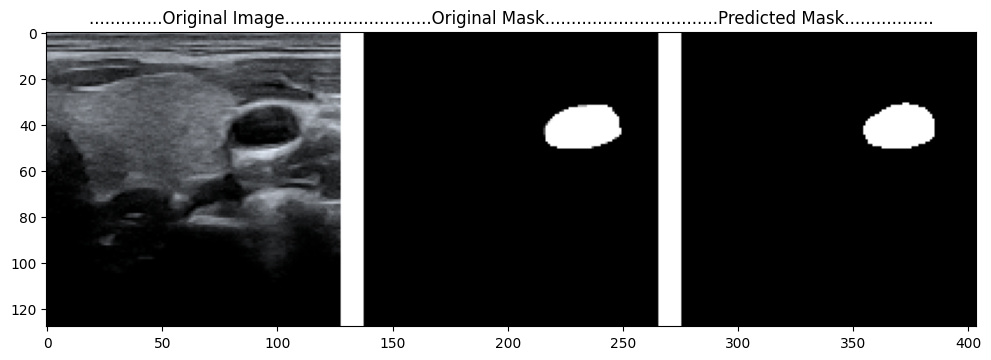

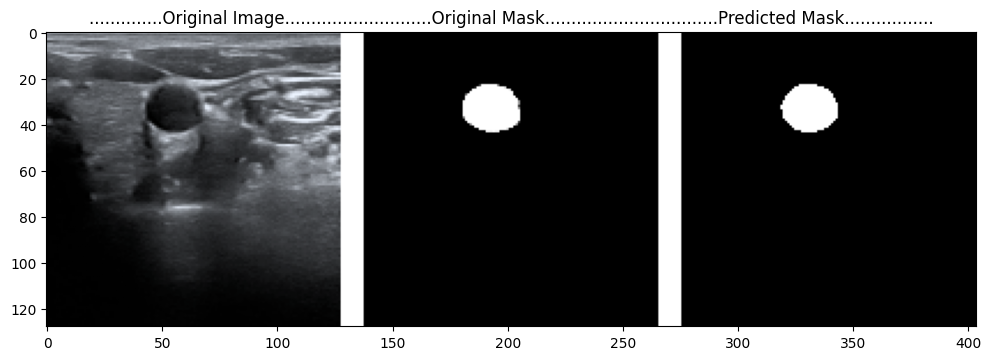

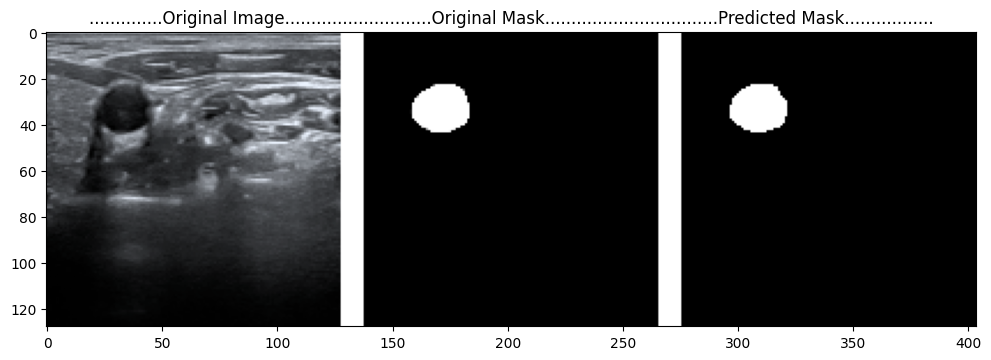

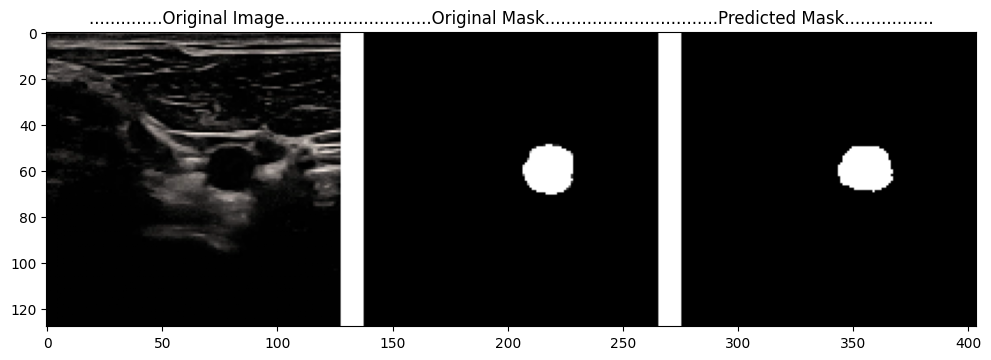

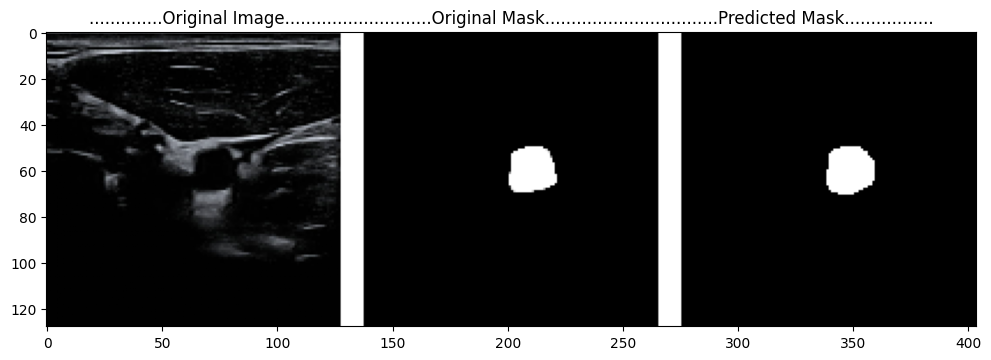

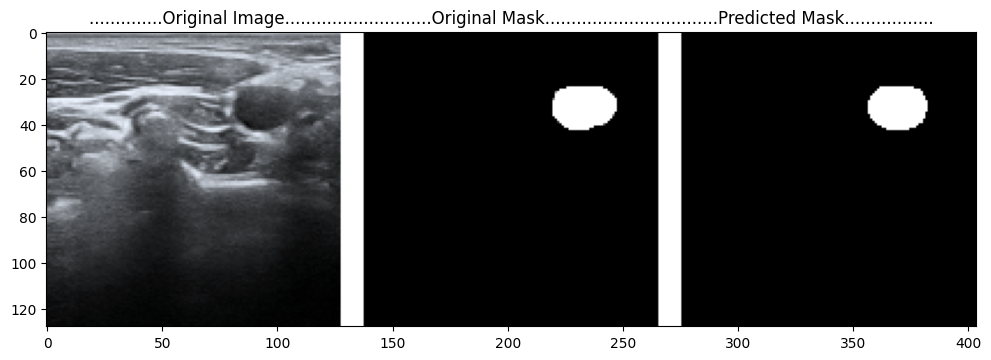

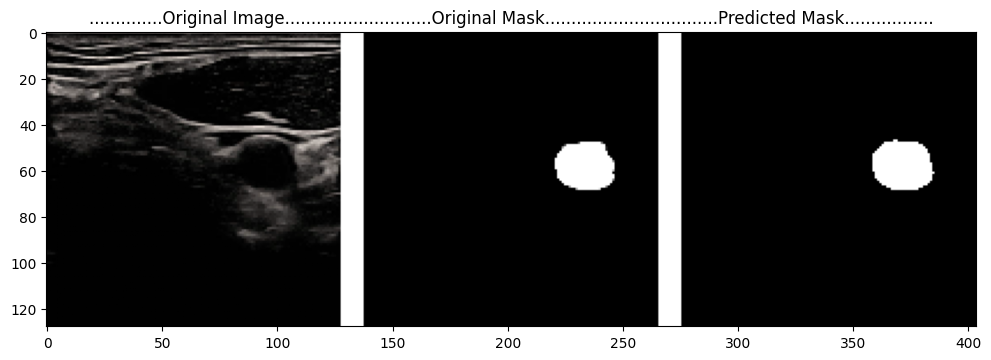

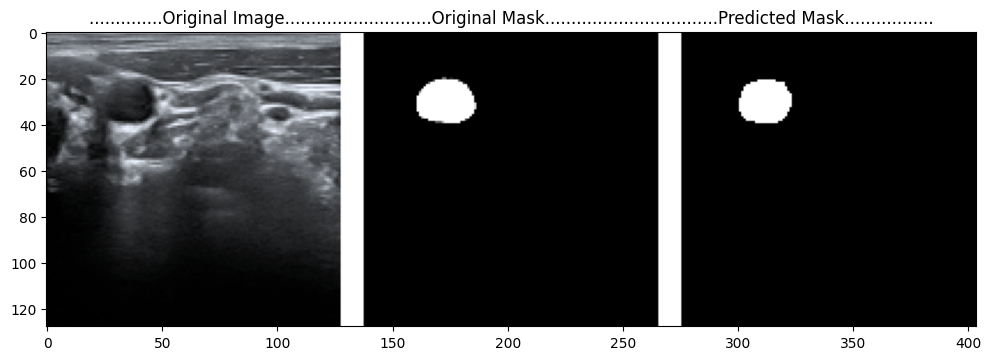

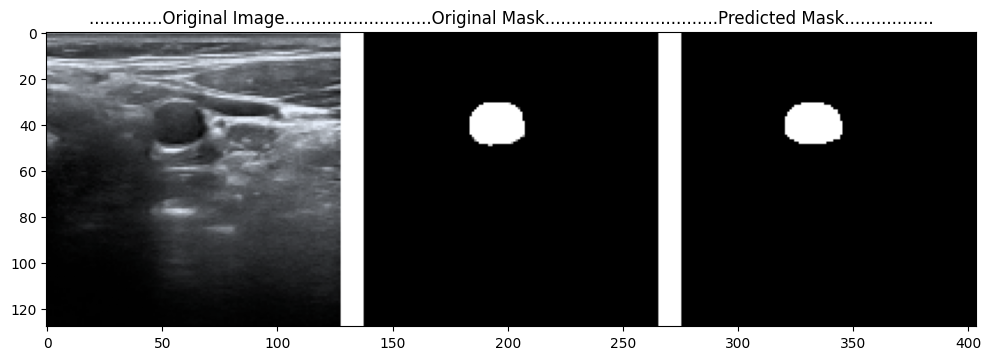

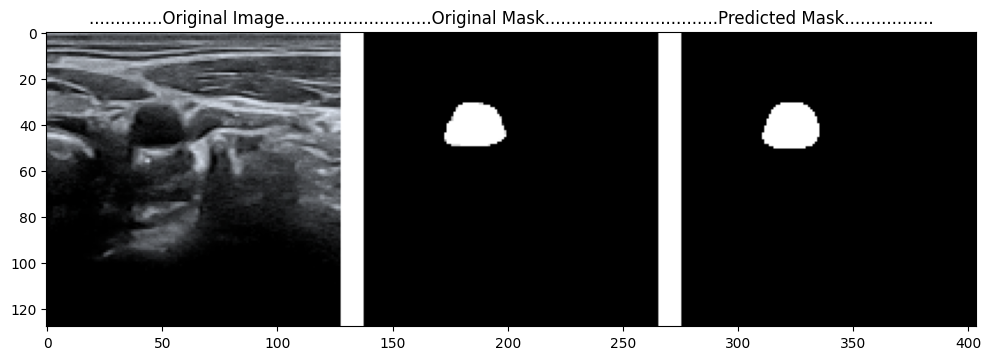

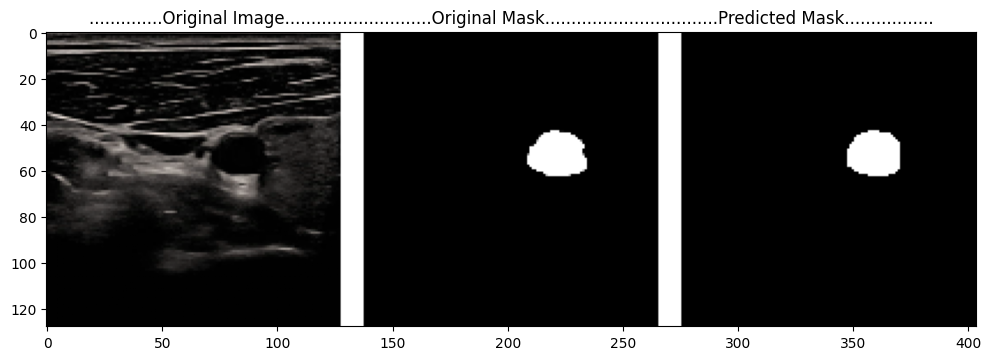

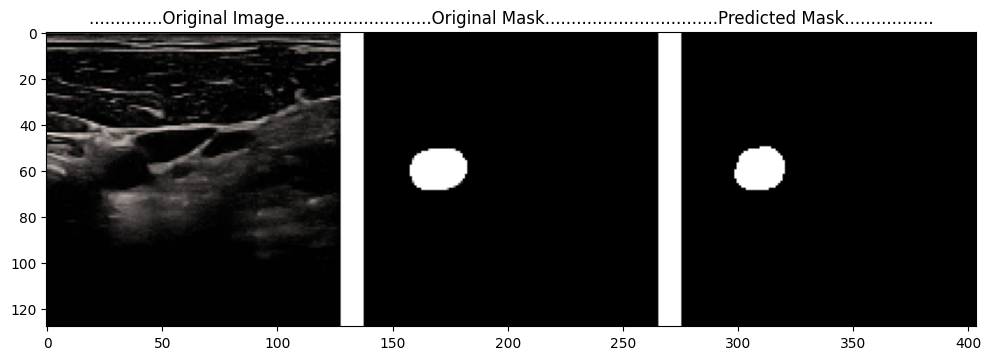

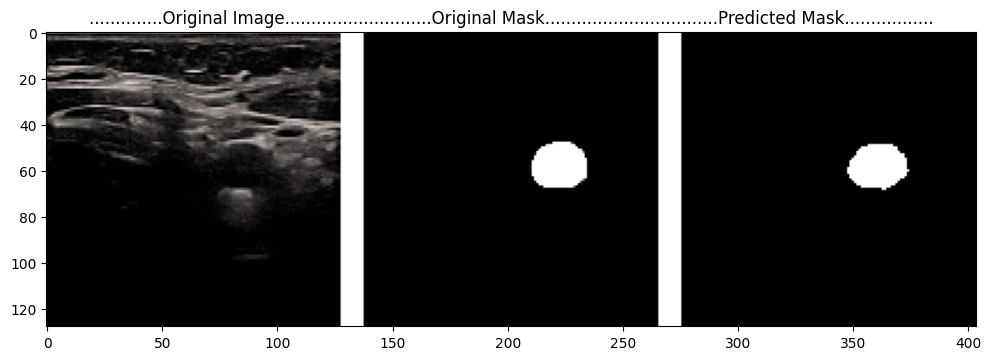

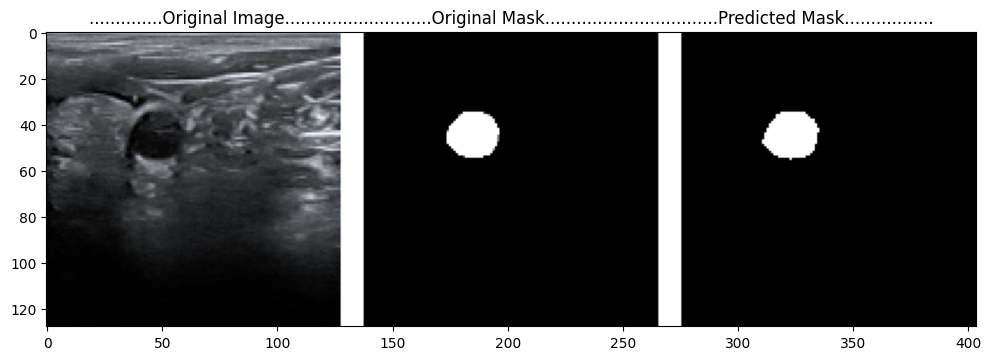

In [47]:
for i, (x, y) in enumerate(zip(test_x[:20], test_y[:20])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    a.set_title("____________Original Image________________________Original Mask_________________________Predicted Mask________________")
    a.set_title("..............Original Image............................Original Mask.................................Predicted Mask.................")
    imgplot = plt.imshow(image)